In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from report_config import ReportConfig

In [2]:
reviews_df = pd.read_csv("./glassdoor_reviews_predicted.csv")

In [3]:
reviews_df["sentiment"] = reviews_df["sentiment"].apply(lambda x: 2 if x == -1 else x)

In [4]:
reviews_df["predicted_sentiment_label"] = reviews_df["predicted_sentiment"].map(
    ReportConfig.SENTIMENT_DICT
)

In [5]:
mean_reviews_count = len(reviews_df) / len(reviews_df["company"].unique())
mean_reviews_count

115.0909090909091

In [6]:
review_counts = reviews_df.groupby("company")["review_id"].count()
sorted_counts = review_counts.sort_values()
median = sorted_counts.median()
median

42.0

In [7]:
sorted_counts

company
Original Soluções Tecnológicas                                 2
Intelecto Sistemas                                             6
Datweb                                                        12
MTI - Empresa Mato-grossense de Tecnologia da Informação      14
Puma Sistemas                                                 16
Ganso Sistemas                                                30
Coplan Consultoria e Planejamento                             32
Tecnomapas                                                    34
Fundação Uniselva                                             36
Liberali                                                      36
MOVERE (Brazil)                                               40
Totem Treinamento e Consultoria em TI                         44
Log, Lab. Inteligência Digital                                50
NBS Informática                                               54
Eco Centauro                                                  74
Agenda Assessoria

## Countplot horizontal

In [8]:
reviews_df = reviews_df.sort_values(by="predicted_sentiment").reset_index()

In [9]:
reviews_df.head(2)

,index,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,predicted_sentiment,predicted_sentiment_label
0,1265,64925288,Cigam Software Corporativo,Estagiário,Funcionário(a) atual,não encontrei nenhum até hoje,2022-05-31,5.0,0,1,0,Neutro
1,1841,75733214,Grupo Bom Futuro,Assistente de pagadoria,Funcionário(a) atual,Não tem contras nada a dizer,2023-04-22,5.0,0,1,0,Neutro


Create a column to order predicted_sentiment as `positive`, `negative` and `neutral` instead of `neutral`, `positive` and `negative`

In [10]:
conditions = [
    (reviews_df["predicted_sentiment"] == 0),
    (reviews_df["predicted_sentiment"] == 1),
    (reviews_df["predicted_sentiment"] == 2),
]

values = [3, 1, 2]

reviews_df["predicted_sentiment_plot"] = np.select(conditions, values)

In [11]:
reviews_df.head(2)

,index,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,predicted_sentiment,predicted_sentiment_label,predicted_sentiment_plot
0,1265,64925288,Cigam Software Corporativo,Estagiário,Funcionário(a) atual,não encontrei nenhum até hoje,2022-05-31,5.0,0,1,0,Neutro,3
1,1841,75733214,Grupo Bom Futuro,Assistente de pagadoria,Funcionário(a) atual,Não tem contras nada a dizer,2023-04-22,5.0,0,1,0,Neutro,3


In [12]:
reviews_df[reviews_df["company"].str.startswith("MTI")]["company"].count()

14

In [13]:
sentiment_counts = (
    reviews_df.groupby(["company", "predicted_sentiment_plot"])
    .size()
    .unstack(fill_value=0)
)

sentiment_counts_reset = sentiment_counts.reset_index()
sentiment_counts_reset.columns = ["company", "1positive", "2negative", "3neutral"]

In [14]:
sentiment_counts

predicted_sentiment_plot,1,2,3
company,,,
Abaco Tecnologia de Informação Ltda,50,50,10
Agenda Assessoria,46,40,10
Amaggi,438,349,69
Cigam Software Corporativo,176,139,39
Coplan Consultoria e Planejamento,15,14,3
DSS Tecnologia,53,52,17
Datweb,7,4,1
Eco Centauro,38,28,8
Fundação Uniselva,17,18,1


In [15]:
# & (
#             sentiment_counts_reset["1positive"]
#             + sentiment_counts_reset["2negative"]
#             + sentiment_counts_reset["3neutral"] >= min_reviews
#         )

In [16]:
def get_bad_rating_companies():
    negative_greater_than_positive = sentiment_counts_reset[
        sentiment_counts_reset["2negative"] > sentiment_counts_reset["1positive"]
    ]

    negative_greater_than_positive = negative_greater_than_positive.sort_values(
        by="2negative", ascending=False
    ).reset_index()

    return list(negative_greater_than_positive["company"].values)

In [17]:
def get_good_rating_companies():
    positive_greater_than_negative = sentiment_counts_reset[
        sentiment_counts_reset["1positive"] > sentiment_counts_reset["2negative"]
    ]

    positive_greater_than_negative = positive_greater_than_negative.sort_values(
        by="1positive", ascending=False
    ).reset_index()

    return list(positive_greater_than_negative["company"].values)

In [18]:
def get_neutral_rating_companies(min_reviews=0):
    positive_equal_to_negative = sentiment_counts_reset[
        sentiment_counts_reset["1positive"] == sentiment_counts_reset["2negative"]
    ]

    return list(positive_equal_to_negative["company"].values)

In [19]:
bad_rating_companies = get_bad_rating_companies()
good_rating_companies = get_good_rating_companies()
neutral_rating_companies = get_neutral_rating_companies()

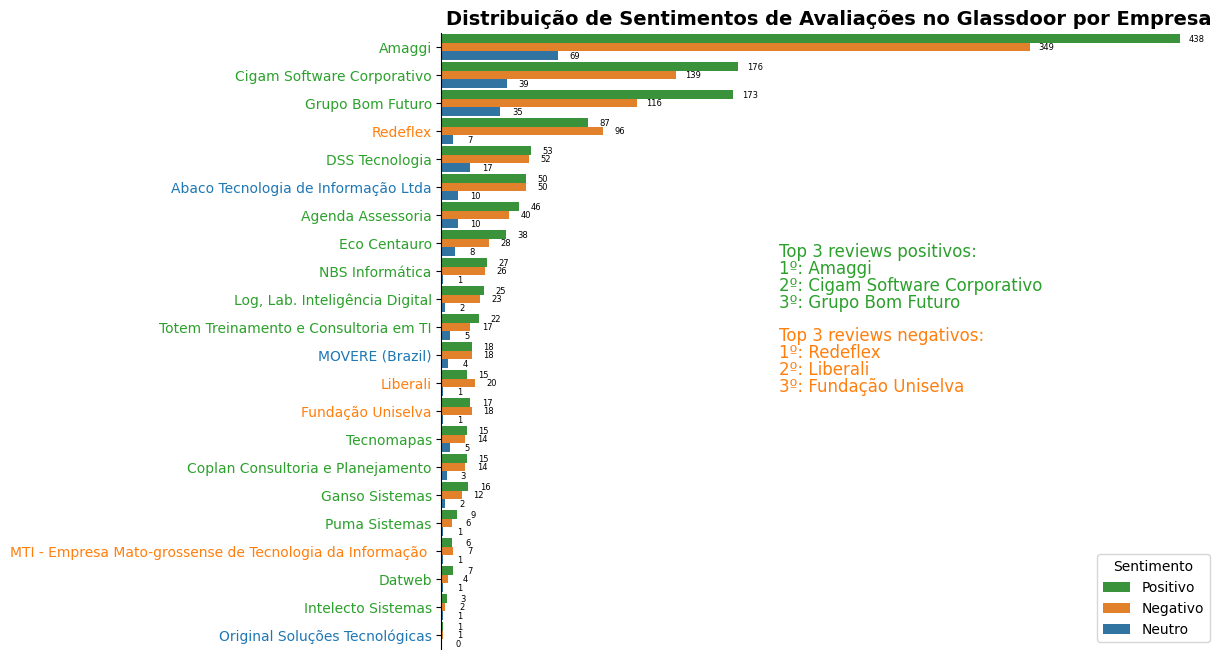

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 8))

# Plot
company_countplot = sns.countplot(
    data=reviews_df,
    y="company",
    hue="predicted_sentiment_plot",
    order=reviews_df["company"].value_counts().index,
    ax=ax,
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    width=0.9,
)

# Highlight Companies
for i, label in enumerate(ax.get_yticklabels()):
    company_name = label.get_text()
    if company_name in bad_rating_companies:
        label.set_color(ReportConfig.NEGATIVE_SENTIMENT_COLOR)

for i, label in enumerate(ax.get_yticklabels()):
    company_name = label.get_text()
    if company_name in good_rating_companies:
        label.set_color(ReportConfig.POSITIVE_SENTIMENT_COLOR)

for i, label in enumerate(ax.get_yticklabels()):
    company_name = label.get_text()
    if company_name in neutral_rating_companies:
        label.set_color(ReportConfig.NEUTRAL_SENTIMENT_COLOR)

# Plot Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width() + 10, (p.get_y() + p.get_height() / 2) + 0.02),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 0),
        textcoords="offset points",
    )

## Top Companies Annotates
y_min, y_max = ax.get_ylim()
y_position = (y_min + y_max) / 2

x_annonate = 200
font_size_annotate = 12
# Top Positive Companies Annotates
ax.annotate(
    "Top 3 reviews positivos:",
    xy=(x_annonate, y_position - 3),
    fontsize=font_size_annotate,
    color=ReportConfig.POSITIVE_SENTIMENT_COLOR,
)

for index, company in enumerate(good_rating_companies[:3]):
    ax.annotate(
        f"{index + 1}º: {company}",
        xy=(x_annonate, y_position - 3 + 0.6 + index * 0.6),
        fontsize=font_size_annotate,
        color=ReportConfig.POSITIVE_SENTIMENT_COLOR,
    )

# Top Negative Companies Annotates
ax.annotate(
    "Top 3 reviews negativos:",
    xy=(x_annonate, y_position),
    fontsize=font_size_annotate,
    color=ReportConfig.NEGATIVE_SENTIMENT_COLOR,
)

for index, company in enumerate(bad_rating_companies[:3]):
    ax.annotate(
        f"{index + 1}º: {company}",
        xy=(x_annonate, y_position + 0.6 + index * 0.6),
        fontsize=font_size_annotate,
        color=ReportConfig.NEGATIVE_SENTIMENT_COLOR,
    )

sns.despine(bottom=True)

plt.xlabel("")
plt.xticks([])

plt.ylabel("")

plt.title(
    "Distribuição de Sentimentos de Avaliações no Glassdoor por Empresa",
    fontdict={
        "weight": "bold",
        "size": ReportConfig.CHART_TITLE_FONT_SIZE,
    },
    loc="center",
)

plt.legend(
    title="Sentimento", labels=["Positivo", "Negativo", "Neutro"], loc="lower right"
)

# plt.savefig(
#     "glassdoor_company_reviews_sentiment_distribution.png",
#     transparent=True,
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()